In [472]:
import numpy as np
import math
import scipy.integrate as sci
import matplotlib.pyplot as plt
import PID

# Маятник с маховиком

$ \theta = \phi + \alpha\\ $
$ \ddot{\theta} = cu \\ $
$ \ddot{\phi} = asin\phi - bu\\ $
Переобозначим : $x_1 = \phi,  x_2 = \dot{x_2},  x_3 = \dot{\theta}\\ $
$$ 
      \begin{cases}
          \dot{x_1} = x_2 \\
          \dot{x_2} = asinx_1 - bu\\
          \dot{x_3} = cu
      \end{cases}\\
$$
$ x_3 $ можем найти в явном виде, поэтому в уравнение не входит 

Точки равновесия: 
    $$ x_2 = 0\\
    sinx_1 = \frac{bu}{a} $$
Получается, что точки равновесия зависят исключительно от управления.
Из третьего уравнения следует, что чтобы гарантировать что маятник достигает положения равновесия, нужно выполнение условия $x_1 = \pi n$

### Linear controllers
#### Classic PID-approach
Линеаризация:
$\begin{pmatrix}
\dot{x_1}\\
\dot{x_2}\\
\end{pmatrix}
= \begin{pmatrix}
0 & 1\\
a & 0\\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\end{pmatrix}
+ \begin{pmatrix}
0\\
-b\\
\end{pmatrix} u $

Не вдаваясь в подробности, получим, что коэффициенты PID-регулятора и полюса замкнутой системы связаны через соотношения:
$$ k_d = \frac{p_1+p_2+p_3}{b}\\ $$
$$ k_p = -\frac{p_1p_2+p_2p_3 + p_1p_3+a}{b}\\ $$
$$ k_i = \frac{p_1p_2p_3}{b}\\ $$

In [483]:
#функция для построения графиков
def Graphs(xx, u):
    t_sol = np.arange(param.t0, param.tf, param.dt)
    ctrl_req = [param.ctrl_req]*len(t_sol)
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.subplot(221)
    plt.plot(t_sol, xx[0])
    plt.plot(t_sol, ctrl_req)
    plt.title('TX')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.grid()

    plt.subplot(222)
    plt.plot(t_sol, xx[1])
    # plt.plot(t_sol, ctrl_req)
    plt.title('TV')
    plt.xlabel('t')
    plt.ylabel('v')
    plt.grid()

    plt.subplot(223)
    plt.plot(t_sol, U)
    # plt.plot(t_sol, ctrl_req)
    plt.title('TU')
    plt.xlabel('t')
    plt.ylabel('u')
    plt.grid()

    plt.subplot(224)
    plt.plot(xx[0], xx[1])
    plt.title('XV')
    plt.xlabel('x')
    plt.ylabel('v')
    plt.grid()

In [484]:
#параметры задачи, заданы в статье
class Parameters(object):
    pass

param = Parameters()
param.m = 1.
param.a = 78.4
param.b = 1.08
param.с = 198
param.p1 = 0
param.p2 = -35
param.p3 = -100
param.ctrl_req = 0
param.dt = 0.01
param.t0 = 0.
param.tf = 1.
param.x0 = [0.12, 0]

In [504]:
#PID-регулятор, сюда включены и реализованы пункты 4.1.1 и 4.2.1
class pid():
    def __init__(self,p, name, task):
        self.task = task
        self.name = name
        if name == 'lin':
            self.kd = (p.p1 + p.p2 + p.p3)/p.b
            self.kp = -(p.p1*p.p2 + p.p1*p.p3 + p.p2*p.p3 + p.a)/p.b
            self.ki = p.p1*p.p2*p.p3/p.b
        elif name == 'nonlin':
            self.kd = -(p.p1 + p.p2 + p.p3)
            self.kp = (p.p1*p.p2 + p.p1*p.p3 + p.p2*p.p3 + p.a)
            self.ki = - p.p1*p.p2*p.p3
        self.integral = 0
        self.error_prev = 0.
    
    def set_ki(self, p):
        self.ki = p.ki

    def control(self,state,p):
        error = p.ctrl_req - state
        self.integral+=error
        u = self.kp*error + self.ki*self.integral + self.kd*(error - self.error_prev)/p.dt
        u1 = np.clip(u,-10,10)
        self.error_prev = error
        return u1
    def ode(self,t,x,p):
        dxdt = np.zeros(2)
        dxdt[0] = x[1]
        if self.name == 'lin':
            dxdt[1] = p.a*x[0] - p.b*self.control(x[0], p)
        elif self.name == 'nonlin':
            dxdt[1] = self.control(x[0], p)
        if self.task == 2:
            dxdt += np.dot(np.array([[1.5, 1.5], [1.5, 1.5]]), x)
        return dxdt
    def solver(self,p):
        t_sol = np.arange(p.t0, p.tf, p.dt)
        x_sol = p.x0
        x_list = []
        y_list = []
        t = 0
        while t < p.tf:
            sol = sci.solve_ivp(lambda t,x: self.ode(t,x,p), (t, t+p.dt), x_sol, t_eval = [t+p.dt],rtol = 1e-1, atol=1e-1)
            t+=p.dt
            x_sol = sol.y.T[-1,:]
            x_list.append(x_sol[0])
            y_list.append(x_sol[1])
        return (x_list, y_list)
    def control_count(self, p):
        a = self.solver(p)
        U = []
        for i in range(len(a[0])):
            new_x = [a[0][i], a[1][i]]
            U.append(self.control(new_x[0], param))
        return U

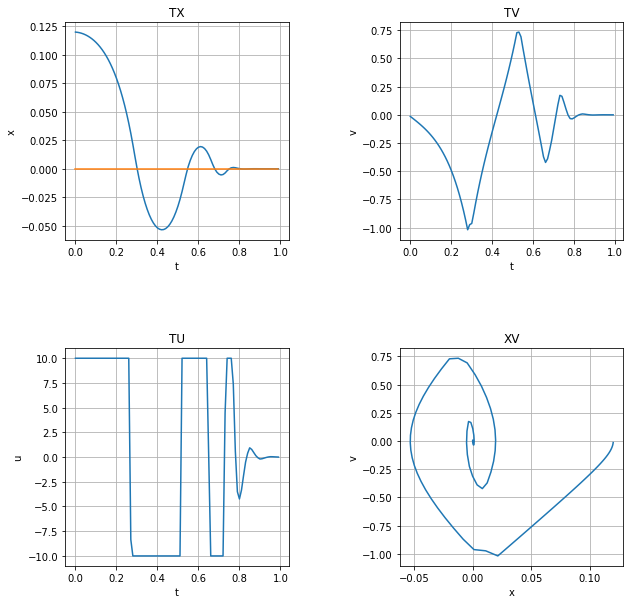

In [505]:
a = pid(param, 'lin',1)
xx = a.solver(param)
U = a.control_count(param)
Graphs(xx, U)

##### Approximate feedback linearization approach
Предполагаем, что управление $u = -k_1x_1 - k_2x_2 $, подставляя в систему выше, получим соотношение между коэффициентами $p_2,p_3$ и $k_1,k_2$
$\begin{pmatrix}
\dot{x_1}\\
\dot{x_2}\\
\end{pmatrix}
= \begin{pmatrix}
0 & 1\\
a+bk_1 & bk_2\\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\end{pmatrix}
 \\$
Решая характеристическое уравнение, получаем для коэффициентов:
$ k_2 = \frac{p_3+p_2}{b}\\ $
$ k_1 = \frac{-p_3p_2-a}{b} $

In [520]:
#Сюда включены и реализованы пункты 4.1.2 и 4.2.2
class approximate():
    def __init__(self,p, name,task):
        self.task = task
        self.name = name
        if name == 'lin':
            self.k1 = (-p.p3*p.p2 - p.a)/p.b
            self.k2 = (p.p3 + p.p2)/p.b
        elif name == 'nonlin':
            self.k1 = p.p2*p.p3
            self.k2 = -p.p2-p.p3
    def control(self,x,p):
        u = -self.k1*x[0]-self.k2*x[1]
        return u
    def ode(self,t,x,p):
        dxdt = np.zeros(2)
        dxdt[0] = x[1]
        if self.name == 'lin':
            dxdt[1] = p.a*x[0] - p.b*self.control(x,p)
        elif self.name == 'nonlin':
            dxdt[1] = self.control(x,p)
        if self.task == 2:
            dxdt += np.dot(np.array([[1.5, 1.5], [1.5, 1.5]]), x)
        return dxdt
    def solver(self,p):
        t_sol = np.arange(p.t0, p.tf, p.dt)
        x_sol = p.x0
        sol = sci.solve_ivp(lambda t,x: self.ode(t,x,p), (p.t0,p.tf), x_sol, t_eval=t_sol, rtol =1e-6, atol=1e-6)
        x_sol = sol.y
#         print(x_sol)
        return x_sol
    def control_count(self, p):
        a = self.solver(p)
        U = []
        for i in range(len(a[0])):
            new_x = [a[0][i], a[1][i]]
            U.append(self.control(new_x, param))
        return U 

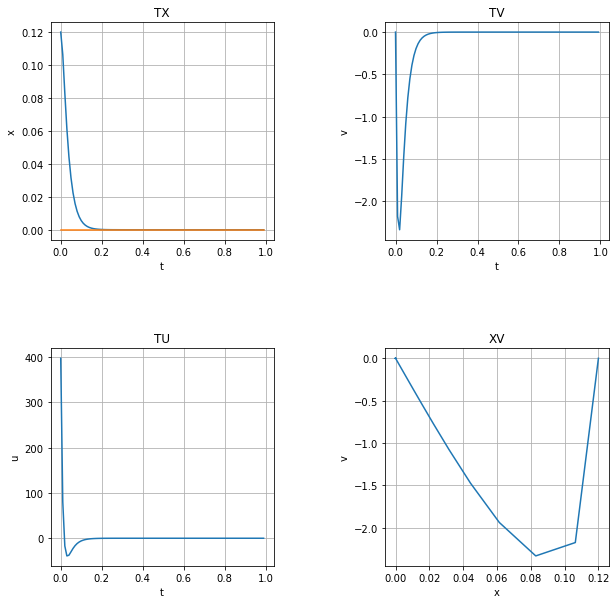

In [507]:
a = approximate(param, 'lin', 1)
xx = a.solver(param)
U = a.control_count(param)
Graphs(xx, U)

Мне пришлось пойти на хитрость, не ограничивая управление, иначе не сходится.

#### Exact feedback linearization approach
$u = \frac{a}{b}sinx_1 - \frac{v}{b}\\ v = \dot{x_2}$
Тогда система преобразуется в:
$ \begin{pmatrix}
\dot{x_1}\\
\dot{x_2}\\
\end{pmatrix}
= \begin{pmatrix}
0 & 1\\
0 & 0\\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\end{pmatrix}
+ \begin{pmatrix}
0\\
1\\
\end{pmatrix}
v \\ $
##### PID-design
Аналогично PID-регулятору выше:
$$ k_d = - (p_1 + p_2 + p_3)\\
k_p = (p_1p_2 + p_2p_3 + p_1p_3)\\
k_i = -p_1p_2p_3 $$

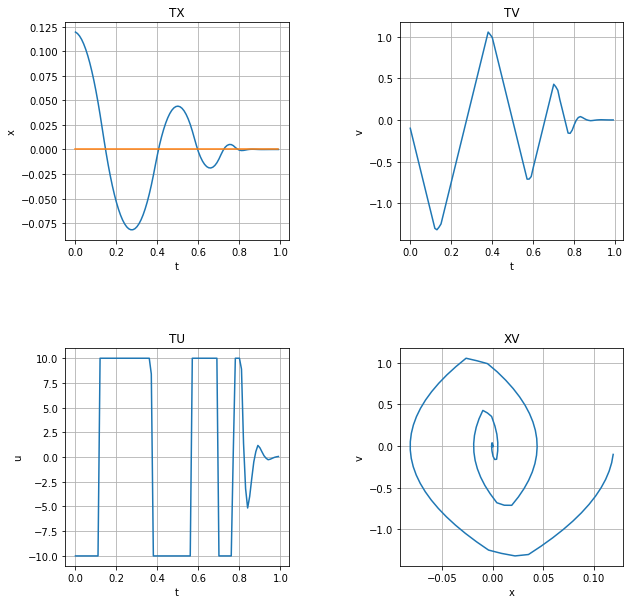

In [510]:
a = pid(param, 'nonlin',1)
xx = a.solver(param)
U = a.control_count(param)
Graphs(xx, U)

##### Feedback design
Аналогично, $v = -k_1x_1-k_2x_2 \\$
$\begin{pmatrix}
\dot{x_1}\\
\dot{x_2}\\
\end{pmatrix}
= \begin{pmatrix}
0 & 1\\
-k_1 & -k_2\\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\end{pmatrix}\\\\ $
Решая характеристическое уравнение, $$ k_2 = -p_3 - p_2$$
$$k_1 = p_3p_2 $$

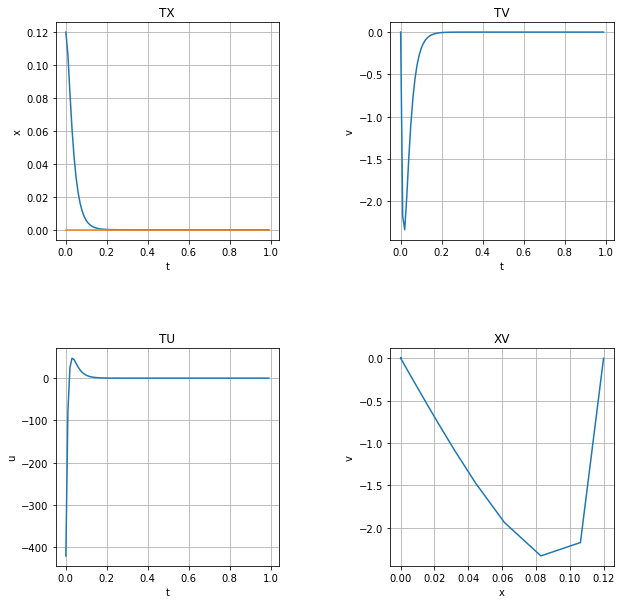

In [511]:
a = approximate(param, 'nonlin', 1)
xx = a.solver(param)
U = a.control_count(param)
Graphs(xx, U)

#### Метод Ляпунова

###### Первый кандидат в функции Ляпунова (устойчивость по Ляпунову): $ \nu(x) = \frac{1}{2}(k_1x_1^2 + x_2^2) + 2asin^2(\frac{1}{2}x_1) \\ $
Нетрудно проверить, что точка равновесия устойчива по Ляпунова, если выбрать в качестве управления $$ u = \frac{1}{b}(k_1x_1 + k_2x_2 + 2asinx_1) \\ \\ $$

###### Второй кандидат в функции Ляпунова (асимптотическая устойчивость): $ \nu(x) = \frac{1}{2}(k_1x_1 + x_2)^2  \\ $
Нетрудно проверить, что точка равновесия устойчива по Ляпунова, если выбрать в качестве управления $$ u = \frac{1}{b}(k_1x_1 + k_2x_2 + 2asinx_1 + \frac{k_1}{k_2}x_2) $$

Рассмотрим две задачи, первая - обычный режим с заданными начальными данными.$ \\ $
Вторая - с добавлением к системе "неопределенностей":
$\begin{pmatrix}
\dot{x_1}\\
\dot{x_2}\\
\end{pmatrix}
= \begin{pmatrix}
x_2\\
asinx_1 - bu\\
\end{pmatrix}
+ \begin{pmatrix}
1.5 & 1.5\\
1.5 & 1.5\\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\end{pmatrix}
$


In [454]:
class Lyapunov_funcs():
    def __init__(self, p, name, task):
        self.name = name
        self.task = task
        self.k1 = 3500
        self.k2 = 135
    def control(self, x, p):
        if self.name == 'f1':
            u = 1/p.b*(self.k1*x[0] + self.k2*x[1] + 2*p.a*np.sin(x[0]))
        elif self.name == 'f2':
            u = 1/p.b*(self.k1*x[0] + self.k2*x[1] + 2*p.a*np.sin(x[0]) + self.k1/self.k2*x[1])
        u = np.clip(u,-10,10)
        return u
    def ode(self,t, x, p):
        dxdt = np.empty(2)
        dxdt[0] = x[1]
        dxdt[1] = p.a*np.sin(x[0]) - p.b*self.control(x,p)
        if self.task == 2:
            dxdt += np.dot(np.array([[1.5, 1.5], [1.5, 1.5]]), x)
        return dxdt
    def rhs(self, x, p):
        if self.task == 1:
            return np.array([ x[1], p.a*np.sin(x[0]) - p.b*self.control(x,p)])
        elif self.task == 2:
            return np.array([ x[1]+1.5*x[0]+1.5*x[1], p.a*np.sin(x[0]) - p.b*self.control(x,p)+1.5*x[0]+1.5*x[1]])
    def solver(self, p):
        t_sol = np.arange(p.t0, p.tf, p.dt)
        x_sol = p.x0
        sol = sci.solve_ivp(lambda t, x: self.ode(t,x, p),(p.t0, p.tf), x_sol, t_eval = t_sol, rtol =1e-6, atol=1e-6)
        x_sol = sol.y
        return x_sol
    def control_count(self, p):
        a = self.solver(p)
        U = []
        for i in range(len(a[0])):
            new_x = [a[0][i], a[1][i]]
            U.append(self.control(new_x, param))
        return U 
    def graphics(self, p):
        t_sol = np.arange(param.t0, param.tf, param.dt)
        ctrl_req = [param.ctrl_req]*len(t_sol)
        plt.figure(figsize=(10,10))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)

        plt.subplot(221)
        plt.plot(t_sol, xx[0])
        plt.plot(t_sol, ctrl_req)
        plt.title('TX')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()

        plt.subplot(222)
        plt.plot(t_sol, xx[1])
        # plt.plot(t_sol, ctrl_req)
        plt.title('TV')
        plt.xlabel('t')
        plt.ylabel('v')
        plt.grid()

        plt.subplot(223)
        plt.plot(t_sol, U)
        # plt.plot(t_sol, ctrl_req)
        plt.title('TU')
        plt.xlabel('t')
        plt.ylabel('u')
        plt.grid()
        
        x1 = np.linspace(-0.5, 0.5, 20)
        x2 = np.linspace(-1, 1, 20)

        X1, X2  = np.meshgrid(x1, x2)                   
        DX1, DX2 = (self.rhs([X1, X2],p))
        M = (np.hypot(DX1, DX2))                        
        M[ M == 0] = 1.                                 
        DX1 /= M                                        
        DX2 /= M
        fig1 = plt.figure(figsize=(8,8))
        ax1 = fig1.add_subplot(1,1,1)

        ax1.set_title("Phase Portrait")
        ax1.quiver(X1, X2, DX1, DX2, M, pivot='mid')
        ax1.grid(True)
        ax1.plot(self.solver(p)[0], self.solver(p)[1], color='red', linewidth = 3)
        ax1.set_xlabel('x')
        ax1.set_ylabel('v')

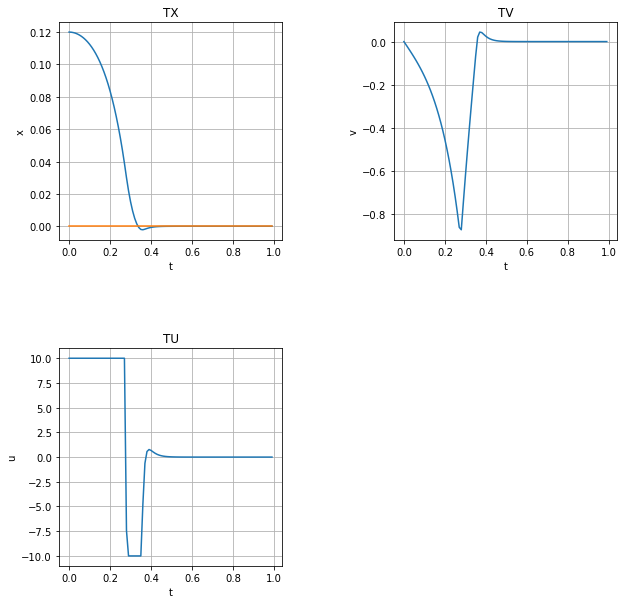

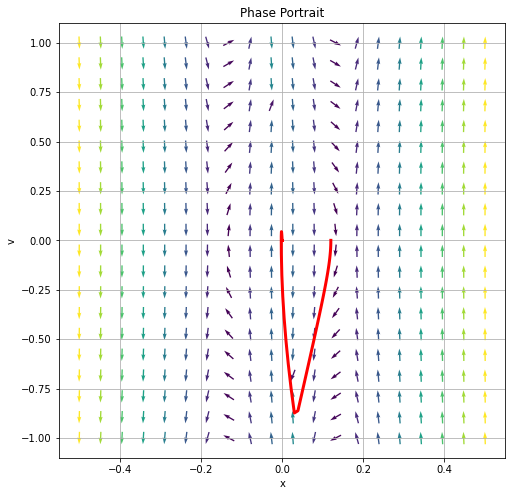

In [503]:
param.x0 = [0.12, 0.]
param.tf = 1
a = Lyapunov_funcs(param, 'f1', 1)
xx = a.solver(param)
U = a.control_count(param)
a.graphics(param)

# Самая важная часть

Теперь можно посмотреть все подходы к управлению системой, чтобы сравнить их работу.

In [517]:
list_of_controllers = ['lin' 'nonlin']
list_of_methods = ['pid', 'approximate feedback', 'lyapunov']
list_of_lyapunov_functions = ['f1', 'f2']
#сделале две из трех задач
list_of_tasks = [1,2]

In [518]:
#задаем управление
ctrl = #значение из списка выше
#задаем метод
appr = #значение из списка выше
#задаем задачу
task = #значение из списка выше
#выбираем функцию Ляпунова
func = #значение из списка выше

SyntaxError: invalid syntax (<ipython-input-518-ad947304c4eb>, line 2)

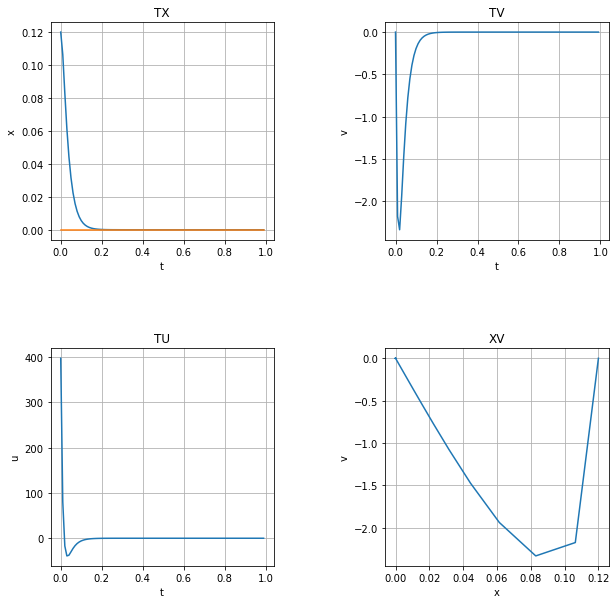

In [519]:
if appr == 'pid':
    a = pid(param, ctrl, task)
    xx = a.solver(param)
    U = a.control_count(param)
    Graphs(xx, U)
elif appr == 'approximate feedback' :
    a = approximate(param, ctrl, task)
    xx = a.solver(param)
    U = a.control_count(param)
    Graphs(xx, U)
elif appr == 'lyapunov':
    a = Lyapunov_funcs(param, func, task)
    xx = a.solver(param)
    U = a.control_count(param)
    a.graphics(param)

### Вывод

Рассмотрены 6 способов приведения системы к устойчивой точке равновесия для двух задач при начальных условиях $ [x_0, v_0] = [0.12, 0] $. В статье подобраны также коэффициенты, которые выражены через полюсы замкнутых систем.

Для первых четырех подходов получились значения, отличающиеся от приведенных в статье. Для PID-регуляторов удалось добиться сходимости при ограничении управления до промежутка [-10, 10]. Для приближенных формул управления ограничение управления приводит к расхождению системы.

Метод Ляпунова с обеими задачами справляется хорошо, также видно, что для второй функции ("f2") имеет место асимптотическая устойчивость.

При других начальных значениях задачу не рассматривала, так как тогда нужно заново подбирать значения для коэффициентов PID-регулятора, а также коэффицинтов при линеаризации управления.